In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pickle

from modules import *

In [2]:
plt.rcParams['font.size'] = 13
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['font.family'] = 'Arial'

In [3]:
# load data
with open('data/data_simulation/data_evidence_accumulation.p', 'rb') as f:
    data = pickle.load(f)
print(data.keys())

n_depth_set = data['n_depth_set']
n_branch = data['n_branch']
n_sample = data['n_sample']
n_world = data['n_world']
n_test = data['n_test']
sig_r = data['sig_r']
max_rewards = data['max_rewards'] # (len(n_depth_set), n_world)
expected_rewards = data['expected_rewards'] # (len(n_depth_set), n_world)
true_rewards = data['true_rewards'] # (len(n_depth_set), n_world, n_branch)
raw_rewards = data['raw_rewards'] # (len(n_depth_set), n_world, n_branch, n_sample, n_test)

with open('data/data_simulation/data_evidence_accumulation_comparison.p', 'rb') as f:
    data_compare = pickle.load(f)

n_sample_set_compare = data_compare['n_sample_set']
expected_rewards_compare = data_compare['expected_rewards']

dict_keys(['n_depth_set', 'n_branch', 'n_sample', 'n_world', 'n_test', 'sig_r', 'max_rewards', 'expected_rewards', 'true_rewards', 'raw_rewards'])


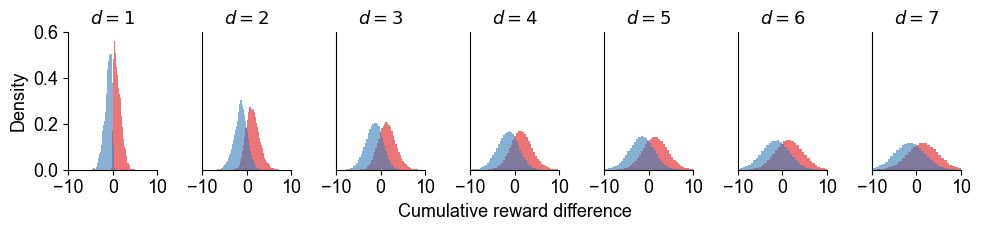

In [4]:
reward_mean_diffs = np.zeros((len(n_depth_set), n_branch))
reward_std_diffs = np.zeros((len(n_depth_set), n_branch))

fig, axes = plt.subplots(nrows = 1, ncols = len(n_depth_set), figsize = (10, 2.5))
colors = plt.colormaps['Set1'].colors

# loop through depths
for i_depth, n_depth in enumerate(n_depth_set):

    # evaluate on the depth
    # rewards: (n_world, n_branch = 2, n_eval)
    # groups: (n_world,). group is by true rewards
    rewards, groups = eval(n_depth = n_depth)

    # compute reward differencea
    reward_diffs = rewards[:, 0, :] - rewards[:, 1, :] # (n_world, n_eval)

    # compute differences for the different groups
    # group 1: true rewards branch 0 > branch 1
    # group 2: true rewards branch 0 < branch 1
    reward_diffs_group1 = reward_diffs[groups, :].reshape(-1) # 1-d
    reward_diffs_group2 = reward_diffs[~groups, :].reshape(-1) # 1-d

    # record mean and std of differences for different groups
    reward_mean_diffs[i_depth, :] = np.array([reward_diffs_group1.mean(), reward_diffs_group2.mean()])
    reward_std_diffs[i_depth, :] = np.array([reward_diffs_group1.std(), reward_diffs_group2.std()])

    # visualize the distribution
    ax = axes[i_depth]
    ax.hist(reward_diffs_group1.reshape(-1), alpha = 0.6, bins = 50, density = True, color = colors[0], label = 'Arm 1 > Arm 2')
    ax.hist(reward_diffs_group2.reshape(-1), alpha = 0.6, bins = 50, density = True, color = colors[1], label = 'Arm 1 < Arm 2')
    ax.set_xlim((-10, 10))
    ax.set_ylim((0, 0.6))
    if i_depth != 0:
        ax.set_yticks([])
    if i_depth == 3:
        ax.set_xlabel('Cumulative reward difference')
    if i_depth == 0:
        ax.set_ylabel('Density')
    ax.set_title(rf'$d={n_depth}$', fontsize = 13)

plt.tight_layout()
# plt.show()
plt.savefig('figures/figures_evidence_accumulation/p_reward_difference_distribution.pdf', bbox_inches = 'tight')

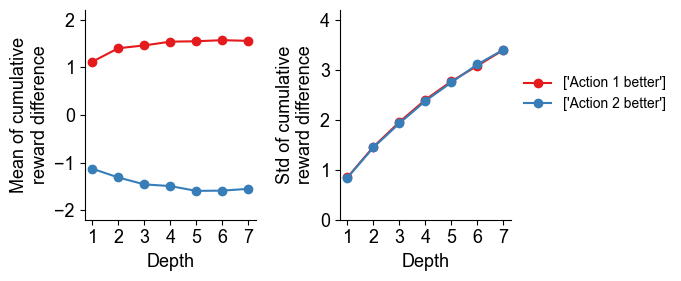

In [5]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (7, 3))

ax = axes[0]
ax.plot(n_depth_set, reward_mean_diffs[:, 0], 'o-', color = colors[0], label = ['Action 1 better'])
ax.plot(n_depth_set, reward_mean_diffs[:, 1], 'o-', color = colors[1], label = ['Action 2 better'])
ax.set_ylim((-2.2, 2.2))
ax.set_xticks(n_depth_set)
ax.set_xlabel('Depth')
ax.set_ylabel('Mean of cumulative\nreward difference')

ax = axes[1]
ax.plot(n_depth_set, reward_std_diffs[:, 0], 'o-', color = colors[0], label = ['Action 1 better'])
ax.plot(n_depth_set, reward_std_diffs[:, 1], 'o-', color = colors[1], label = ['Action 2 better'])
ax.set_ylim((0, 4.2))
ax.set_xticks(n_depth_set)
ax.set_xlabel('Depth')
ax.set_ylabel('Std of cumulative\nreward difference')

ax.legend(bbox_to_anchor = (1, 0.6), loc = 'center left', fontsize = 10, frameon = False)
plt.tight_layout()
# plt.show()
plt.savefig('figures/figures_evidence_accumulation/p_reward_difference_summary.pdf', bbox_inches = 'tight')

In [6]:
cum_evidence = np.zeros((len(n_depth_set), n_world, n_test, n_sample))
abs_cum_evidence = np.zeros((len(n_depth_set), n_world, n_test, n_sample))

# loop through depths
for i_depth, n_depth in enumerate(n_depth_set):
    
    # loop through environments
    for i_world in range(n_world):

        # loop throught tests
        for i_test in range(n_test):

            # get rewards and compute difference
            rawrew = raw_rewards[i_depth, i_world, :, :, i_test] # (n_branch, n_sample)
            rawrew_diff = (rawrew[0, :] - rawrew[1, :]) # (n_sample,)

            # get true rewards
            truerew = true_rewards[i_depth, i_world, :] # (n_branch,)
            
            # compute evidence
            cum_evidence[i_depth, i_world, i_test, :] = cum_log_LR(
                x = rawrew_diff,
                mu = reward_mean_diffs[i_depth, :], # (n_branch,)
                sigma = reward_std_diffs[i_depth, :].mean() # (b_branch,) -> (1,). use the mean std
            )
            
            abs_cum_evidence[i_depth, i_world, i_test, :] = cum_log_LR(
                x = rawrew_diff * np.sign(truerew[0] - truerew[1]),
                mu = reward_mean_diffs[i_depth, :], # (n_branch,)
                sigma = reward_std_diffs[i_depth, :].mean() # (b_branch,) -> (1,). use the mean std
            )

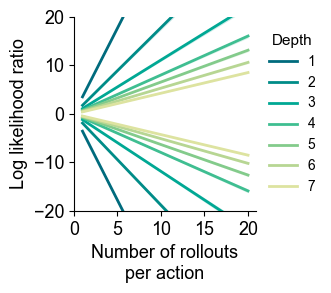

In [7]:
colors = ['#006B7D', '#008C88', '#00A894', '#3FBE91', '#83CB8B', '#B7D693', '#DDE3A0']

plt.figure(figsize = (3.5, 3.12))

for i_depth, n_depth in enumerate(n_depth_set):

    for i in range(2):
        # get index based on true rewards
        if i == 0:
            index = (true_rewards[i_depth, :, 0] > true_rewards[i_depth, :, 1])
            label = i_depth
        elif i == 1:
            index = (true_rewards[i_depth, :, 0] < true_rewards[i_depth, :, 1])
            label = None
            
        cumevi = cum_evidence[i_depth, index, :, :].mean(axis = 1)
        m = np.mean(cumevi, axis = 0)
        s = np.std(cumevi, axis = 0) / np.sqrt(cumevi.shape[0])
    
        plt.plot(np.arange(1, n_sample + 1), m, markersize = 5, color = colors[i_depth], label = label, lw = 2)
        plt.fill_between(np.arange(1, n_sample + 1), m - s, m + s, color = colors[i_depth], alpha = 0.2, linewidth = 0)
        
plt.ylim(-20, 20)
plt.xticks(np.arange(0, n_sample + 1, 5))
plt.xlabel('Number of rollouts\nper action')
plt.ylabel('Log likelihood ratio')

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, n_depth_set, bbox_to_anchor = (1, 0.5), loc = 'center left', fontsize = 10, frameon = False, title = 'Depth', title_fontsize = '11')
plt.tight_layout()
# plt.show()
plt.savefig('figures/figures_evidence_accumulation/p_evidence_depth.pdf', bbox_inches = 'tight')

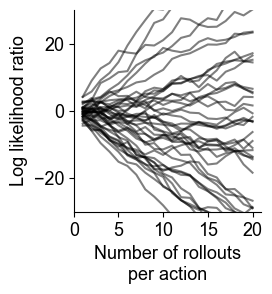

In [8]:
plt.figure(figsize = (2.9, 3.2))

for i_world in range(40):
    plt.plot(np.arange(1, n_sample + 1), cum_evidence[2, i_world, 2, :], color = 'k', alpha = 0.5)
    plt.xticks(np.arange(0, n_sample + 1, 5))
    plt.ylim(-30, 30)
    plt.xlabel('Number of rollouts\nper action')
    plt.ylabel('Log likelihood ratio')

plt.tight_layout()
# plt.show()
plt.savefig('figures/figures_evidence_accumulation/p_evidence_raw.pdf', bbox_inches = 'tight')

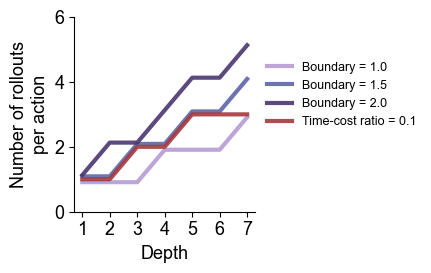

In [9]:
plt.figure(figsize = (4.5, 2.92))
colors = ['#B79BD4','#5D66A8','#4A3570','#A43A3F']
jitters = [-0.09, 0.09, 0.13]

# set 3 thresholds
for i, threshold in enumerate([1, 1.5, 2]):

    n_rollouts = np.zeros((len(n_depth_set)))

    for i_depth, n_depth in enumerate(n_depth_set):

        abs_cumevi = abs_cum_evidence.mean(axis = 2)[i_depth, :, :] # (n_world, n_sample) # average over tests and compute for a depth
        m = np.mean(abs_cumevi, axis = 0)
        s = np.std(abs_cumevi, axis = 0) / np.sqrt(abs_cumevi.shape[0])
        n_rollouts[i_depth] = np.arange(1, n_sample + 1)[np.argmax(m > threshold)]

    plt.plot(n_depth_set, n_rollouts + jitters[i], markersize = 5, lw = 3, color = colors[i], label = 'Boundary = %.1f' % threshold, alpha = 0.9, zorder = 5)

n_sample_set = data_compare['n_sample_set']
expected_rewards = data_compare['expected_rewards']

t_ratio = 1 / 10
exrew = expected_rewards_compare / (1 + np.array(n_sample_set_compare)[:, None] * t_ratio)
n_rollouts_compare = exrew.mean(axis = -1).argmax(axis = 1)
plt.plot(n_depth_set, n_rollouts_compare, markersize = 5, lw = 3, color = colors[-1], label = 'Time-cost ratio = %.1f' % t_ratio, alpha = 0.9, zorder = 10)

plt.xticks(n_depth_set)
plt.ylim((0, np.max(n_rollouts) + 1))
plt.xlabel('Depth')
plt.ylabel('Number of rollouts\nper action')
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, labels, bbox_to_anchor = (1, 0.6), loc = 'center left', fontsize = 9, frameon = False)
plt.tight_layout()
# plt.show()
plt.savefig('figures/figures_evidence_accumulation/p_boundary.pdf', bbox_inches = 'tight')

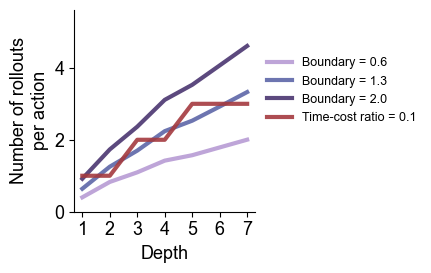

In [10]:
plt.figure(figsize = (4.5, 2.92))
colors = ['#B79BD4','#5D66A8','#4A3570','#A43A3F']

n_rollouts = np.zeros((len(n_depth_set)))

# set 3 thresholds
for i, threshold in enumerate([0.6, 1.3, 2]):
    
    mask = abs_cum_evidence > threshold
    has_exceed = mask.any(axis = -1)
    n_rollouts = np.argmax(mask, axis = -1)
    n_rollouts_masked = np.where(has_exceed, n_rollouts, np.nan)
    n_rollouts = np.nanmean(n_rollouts_masked, axis = 1).mean(axis = 1)

    plt.plot(n_depth_set, n_rollouts, lw = 3, color = colors[i], label = 'Boundary = %.1f' % threshold, alpha = 0.9, zorder = 5)

n_sample_set = data_compare['n_sample_set']
expected_rewards = data_compare['expected_rewards']

t_ratio = 0.1
exrew = expected_rewards_compare / (1 + np.array(n_sample_set_compare)[:, None] * t_ratio)
n_rollouts_boundary_compare = exrew.mean(axis = -1).argmax(axis = 1)
plt.plot(n_depth_set, n_rollouts_boundary_compare, lw = 3, color = colors[-1], label = 'Time-cost ratio = %.1f' % t_ratio, alpha = 0.9, zorder = 10)

plt.xticks(n_depth_set)
plt.ylim((0, np.max(n_rollouts) + 1))
plt.xlabel('Depth')
plt.ylabel('Number of rollouts\nper action')
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, labels, bbox_to_anchor = (1, 0.6), loc = 'center left', fontsize = 9, frameon = False)
plt.tight_layout()
# plt.show()
plt.savefig('figures/figures_evidence_accumulation/p_boundary.pdf', bbox_inches = 'tight')

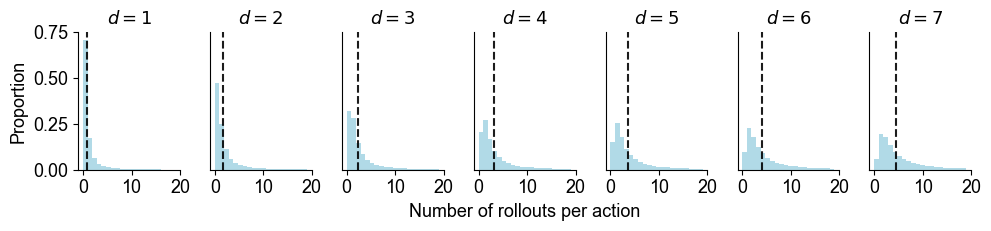

In [11]:
threshold = 2
n_rollouts = np.argmax(abs_cum_evidence > threshold, axis = -1)
mask = (abs_cum_evidence > threshold)  # shape (..., T)
has_exceed = np.any(mask, axis = -1)

plt.figure(figsize = (10, 2.5))
for i in range(n_depth):
    plt.subplot(1, 7, i + 1)
    plt.hist(n_rollouts[i][has_exceed[i]].reshape(-1), bins = 20, density = True, color = 'lightblue', alpha = 0.95)
    plt.axvline(x = n_rollouts[i][has_exceed[i]].mean(), linestyle = '--', color = 'k', alpha = 0.89)
    plt.ylim((0, 0.75))
    plt.xticks([0, 10, 20])
    if i > 0:
        plt.yticks([])
    if i == 3:
        plt.xlabel('Number of rollouts per action')
    if i == 0:
        plt.ylabel('Proportion')
    plt.title(rf'$d={i + 1}$', fontsize = 13)
plt.tight_layout()
# plt.show()
plt.savefig('figures/figures_evidence_accumulation/p_distribution.pdf', bbox_inches = 'tight')